Data downloaded from https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/. Specifically, the Wiki, faces-only data.

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from datetime import datetime

In [4]:
from datetime import timedelta

In [5]:
import scipy.io
mat = scipy.io.loadmat('wiki.mat')

In [6]:
mat['wiki'][0]

array([(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
               array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
               array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
               array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
               array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
               array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
             dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
               array(['Dettmar Cramer'], dtype='<U14'),
               array(['Marc Okrand'], dtype='<U11'), ...,
               array(['Michael Wiesinger'], dtype='<U17'),
               array(['Johann Grugger'], dtype='<U14'),
               array(['Greta Van Susteren'], dtype='<U18')]], dtype=ob

In [7]:
# Preprocessing code from Walk with fastai (Zachary Mueller): https://walkwithfastai.com/Scalar_Regression
def prepare_dataframe(mat):
    "Builds wiki_crop DataFrame based on https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/"
    instances = mat['wiki'][0][0][0].shape[1]
    columns = ['dob', 'photo_taken', 'path', 'gender', 'name', 'face_location', 'face_score', 'second_face_score']
    df = pd.DataFrame(index=range(0, instances), columns=columns)
    for i in mat:
        if i == 'wiki':
            curr_arr = mat[i][0][0]
            for j, val in enumerate(curr_arr):
                df[columns[j]] = pd.DataFrame(val[0])

    ### Python datatime conversion
    df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)
    df['age'] = df['photo_taken'] - df['date_of_birth']

    ## Data cleaning
    df = df[df['face_score'] != -np.inf] # picture doesn't include faces
    df = df[df['second_face_score'].isna()] # more than one face
    df = df[df['face_score'] > 3] # has a score
    df = df[df['age'] < 100] # older than 100 (mostly paintings)
    df = df[df['age'] > 0] # unborn people
    df = df[['path', 'photo_taken' ,'age']]
    df['photo_taken'] = df['photo_taken'] - df['photo_taken'].min()
    df['path'] = df['path'].apply(lambda x: x[0])
    return df

def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) \
    + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
    - timedelta(days=366)
    return exact_date.year

In [8]:
df = prepare_dataframe(mat)

In [9]:
df

,path,photo_taken,age
0,17/10000217_1981-05-05_2009.jpg,69,28
2,12/100012_1948-07-03_2008.jpg,68,60
4,16/10002116_1971-05-31_2012.jpg,72,41
5,02/10002702_1960-11-09_2012.jpg,72,52
6,41/10003541_1937-09-27_1971.jpg,31,34
...,...,...,...
62321,38/9996938_1937-02-15_1968.jpg,28,31
62322,46/9996946_1943-11-01_1968.jpg,28,25
62323,49/9996949_1937-04-17_1963.jpg,23,26
62325,09/9998109_1972-12-27_2013.jpg,73,41


In [10]:
df['photo_taken'].value_counts(normalize=True, ascending=False)

72    0.110397
73    0.107429
74    0.105037
71    0.096354
70    0.080007
        ...   
55    0.001418
51    0.001418
54    0.001373
45    0.001329
52    0.001240
Name: photo_taken, Length: 76, dtype: float64

<Axes: title={'center': 'Histogram of Year Taken (Years elapsed since 1940)'}, ylabel='Frequency'>

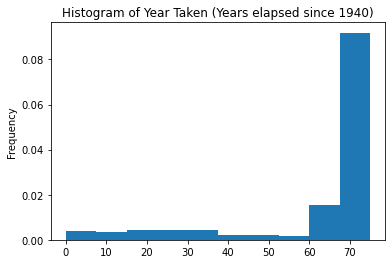

In [11]:
df['photo_taken'].plot.hist(density=True, title='Histogram of Year Taken (Years elapsed since 1940)')

In [12]:
df['photo_taken'].value_counts(normalize=True).iloc[:10]

72    0.110397
73    0.107429
74    0.105037
71    0.096354
70    0.080007
69    0.075799
68    0.062243
75    0.051655
67    0.048642
66    0.026536
Name: photo_taken, dtype: float64

<Axes: ylabel='Frequency'>

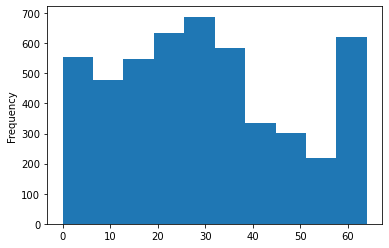

In [15]:
df.loc[df.photo_taken<65, 'photo_taken'].plot.hist()

In [50]:
df.loc[df.photo_taken<65, 'photo_taken']

6        31
10       10
11       29
27       46
28       29
         ..
62317    31
62318    22
62321    28
62322    28
62323    23
Name: photo_taken, Length: 4965, dtype: uint16

In [52]:
df['photo_taken']

0        69
2        68
4        72
5        72
6        31
         ..
62321    28
62322    28
62323    23
62325    73
62327    68
Name: photo_taken, Length: 22573, dtype: uint16

<Axes: ylabel='Frequency'>

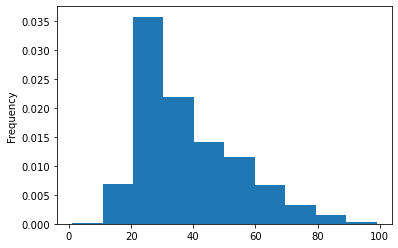

In [35]:
df['age'].plot.hist(density=True)

<Axes: ylabel='Frequency'>

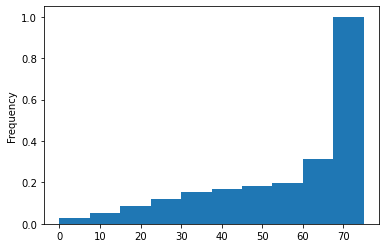

In [28]:
df['photo_taken'].plot.hist(cumulative=True, density=True)

In [26]:
df['photo_taken'].quantile(0.2)

61.0

In [10]:
base_path = '/share/data/willett-group/climate/data/wiki_crop/'

In [11]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim


# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, base_path = '/share/data/willett-group/climate/data/'):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(base_path+img_path)
        response = torch.tensor(self.dataframe.iloc[idx]['photo_taken'], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, response
# Custom transform function
def convert_grayscale_to_rgb(image):
    if image.mode != 'RGB':
        return image.convert('RGB')
    return image

# Transforms
transform = transforms.Compose([
    transforms.Lambda(convert_grayscale_to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset and DataLoader
dataset = CustomImageDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

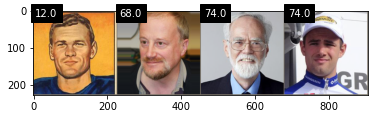

In [12]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Modified imshow function with label positions
def imshow(img, labels, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], num_images_per_row=4):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    # Get the height and width of the image grid
    grid_height, grid_width, _ = img.shape

    # Height of each image
    img_height = grid_height // (len(labels) // num_images_per_row)

    # Display labels
    for idx, label in enumerate(labels):
        x = (idx % num_images_per_row) * img_height
        y = (idx // num_images_per_row) * img_height
        plt.text(x + 5, y + 15, label, color='white', backgroundcolor='black')

    plt.show()

# Get a batch of training data
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Make a grid from batch
out = torchvision.utils.make_grid(images)

# Convert labels to a list of strings if necessary
labels = [str(label.item()) for label in labels]

imshow(out, labels, num_images_per_row=4)


In [13]:
# Dataset and DataLoader
dataset = CustomImageDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

In [14]:
%%time
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

model_features = torch.nn.Sequential(*(list(model.children())[:-1]))

for param in model_features.parameters():
    param.requires_grad = False

model_features.to('cuda')

CPU times: user 2.26 s, sys: 1.57 s, total: 3.82 s
Wall time: 4.12 s


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [15]:
model.fc.in_features

512

In [16]:
%%time
model_features(images.to('cuda')).squeeze().cpu().numpy().shape

CPU times: user 560 ms, sys: 304 ms, total: 864 ms
Wall time: 865 ms


(4, 512)

In [17]:
X = np.zeros((df.shape[0], model.fc.in_features))
y = np.zeros((df.shape[0]))

In [18]:
X.shape

(22573, 512)

In [19]:
y.shape

(22573,)

In [20]:
from tqdm import tqdm

In [21]:
i = 0
for images, labels in tqdm(dataloader):
    num_entries = images.shape[0]

    X[i:(i+num_entries)] = model_features(images.to('cuda')).squeeze().cpu().numpy()

    y[i:(i+num_entries)] = labels.numpy()

    i = i + num_entries

100%|██████████| 89/89 [02:01<00:00,  1.36s/it]


In [22]:
y

array([69., 68., 72., ..., 23., 73., 68.])

In [23]:
np.save('IMDB_WIKI_RESNET18_y_date.npy', y)

In [24]:
np.save('IMDB_WIKI_RESNET18_X.npy', X)

In [26]:
X.shape

(22573, 512)

In [42]:
df

,path,age
0,17/10000217_1981-05-05_2009.jpg,28
2,12/100012_1948-07-03_2008.jpg,60
4,16/10002116_1971-05-31_2012.jpg,41
5,02/10002702_1960-11-09_2012.jpg,52
6,41/10003541_1937-09-27_1971.jpg,34
...,...,...
62321,38/9996938_1937-02-15_1968.jpg,31
62322,46/9996946_1943-11-01_1968.jpg,25
62323,49/9996949_1937-04-17_1963.jpg,26
62325,09/9998109_1972-12-27_2013.jpg,41


In [26]:
images.device

device(type='cpu')

In [130]:
%%time
# Get a batch of training data
dataiter = iter(dataloader)
images, labels = next(dataiter)

CPU times: user 1.7 s, sys: 196 ms, total: 1.89 s
Wall time: 3.43 s


In [116]:
images.device

device(type='cpu')

In [118]:
model_features.to('cuda')

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [119]:
for param in model_features.parameters():
    param.requires_grad = False

In [121]:
images.to('cuda')

tensor([[[[-1.5357, -1.5699, -1.6384,  ..., -1.4500, -1.4500, -1.3644],
          [-1.5870, -1.6213, -1.6555,  ..., -1.4500, -1.4329, -1.3644],
          [-1.5699, -1.5699, -1.6042,  ..., -1.4500, -1.4158, -1.3644],
          ...,
          [-1.7412, -1.7240, -1.7583,  ..., -1.5528, -1.1932, -1.2274],
          [-1.8268, -1.8268, -1.8439,  ..., -1.3130, -1.2959, -1.5357],
          [-1.8097, -1.8782, -1.8782,  ..., -1.2617, -1.5870, -1.8268]],

         [[-1.1078, -1.1253, -1.1954,  ..., -1.3179, -1.3179, -1.2479],
          [-1.1954, -1.1779, -1.2304,  ..., -1.3179, -1.3004, -1.2479],
          [-1.2129, -1.1954, -1.2129,  ..., -1.3179, -1.2829, -1.2304],
          ...,
          [-1.4405, -1.4230, -1.4580,  ..., -1.4230, -1.0903, -1.1429],
          [-1.5280, -1.5280, -1.5455,  ..., -1.1779, -1.1954, -1.4580],
          [-1.5105, -1.5805, -1.5805,  ..., -1.1253, -1.4930, -1.7731]],

         [[-0.7238, -0.7413, -0.8110,  ..., -0.8807, -0.8807, -0.8110],
          [-0.7936, -0.7936, -

In [123]:
model_features.device

AttributeError: 'Sequential' object has no attribute 'device'

In [122]:
images.device

device(type='cpu')

In [131]:
%%time
model_features(images.to('cuda')).squeeze().shape

CPU times: user 62.2 ms, sys: 10.7 ms, total: 72.9 ms
Wall time: 69.3 ms


torch.Size([256, 512])

In [132]:
df

,path,age
0,17/10000217_1981-05-05_2009.jpg,28
2,12/100012_1948-07-03_2008.jpg,60
4,16/10002116_1971-05-31_2012.jpg,41
5,02/10002702_1960-11-09_2012.jpg,52
6,41/10003541_1937-09-27_1971.jpg,34
...,...,...
62321,38/9996938_1937-02-15_1968.jpg,31
62322,46/9996946_1943-11-01_1968.jpg,25
62323,49/9996949_1937-04-17_1963.jpg,26
62325,09/9998109_1972-12-27_2013.jpg,41
